In [1]:
import warnings
from pathlib import Path

import iris
import iris.util
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from tqdm.notebook import tqdm as tqdm

In [2]:
from aeolus.const import init_const
from aeolus.model import um
from aeolus.plot import add_custom_legend
from aeolus.synthobs import calc_geom_mean_mirrored, calc_transmission_spectrum

In [3]:
from util_commons import ABSORBERS, PLANETS, ROSE_SUITES
from util_mypaths import path_to_constants

In [4]:
warnings.filterwarnings("ignore", module="iris")
warnings.filterwarnings("ignore", module="aeolus")
iris.FUTURE.datum_support = True
rcParams["mathtext.default"] = "regular"

In [5]:
# Project
planet = "wasp96b"
PLANET = [planet]
PLANET_CONSTS = [init_const(planet, directory=path_to_constants)]
path_to_project = Path.home() / "projects" / planet
# Spectral resolution
from_2_microns = False  # use data longwards of 2 microns only and CHOOSE CORRECT SPECTRAL FILE
# Absorbers
absrbrs = [
    "all",
    "h2_h2_cia",
    "h2_he_cia",
    "li",
    "na",
    "k",
    "rb",
    "cs",
    "ch4",
    "co",
    "co2",
    "h2o",
    "hcn",
    "nh3",
]
# Checks
check_night_vs_day = False
check_save_nc = False

In [6]:
# Check night vs day calls. Night should look like cc and day like o.
if check_night_vs_day:
    checks = {}
    for planet, planet_const in zip(PLANET, PLANET_CONSTS):
        checks[planet] = {}
        for exp in ["equilibrium", "kinetics"]:
            checks[planet][exp] = {}
            for mdh in ["mdh_0", "mdh_1"]:
                checks[planet][exp][mdh] = {}
                for tK in ["tK_6"]:
                    checks[planet][exp][mdh][tK] = {}
                    if exp == "kinetics" and mdh == "mdh_1" and tK == "tK_6":
                        number = 5  # only this was run for 1500 days
                    else:
                        number = 0
                    for absrbr in tqdm(absrbrs):
                        checks[planet][exp][mdh][tK][absrbr] = {}
                        path_to_raw = ROSE_SUITES[planet][exp][mdh][tK]["dir_for_data"] / "raw"
                        if from_2_microns:
                            # These were calculated on umserve, hence day 0
                            fname_day = f"atmosa.pi00000000_00_day_{absrbr}_from_2_microns"
                            fname_night = f"atmosa.pi00000000_00_night_{absrbr}_from_2_microns"
                        else:
                            # These were calculated on DiRAC, hence day 1000 or 1500
                            fname_day = f"atmosa.pi0000001{number}00_00_day_{absrbr}"
                            fname_night = f"atmosa.pi0000001{number}00_00_night_{absrbr}"
                        tran_flux_day = iris.load_cube(path_to_raw / fname_day)
                        tran_flux_night = iris.load_cube(path_to_raw / fname_night)
                        checks[planet][exp][mdh][tK][absrbr] = {
                            "tran_flux_day": tran_flux_day,
                            "tran_flux_night": tran_flux_night,
                        }
    # Plot this check
    for absrbr in absrbrs:
        fig, axs = plt.subplots(4, 2, sharex=True, constrained_layout=True)
        fig.suptitle(absrbr)
        for exp, axrow in zip(["equilibrium", "kinetics"], axs[0:2]):
            for mdh, ax in zip(["mdh_0", "mdh_1"], axrow):
                ax.set_title("night", loc="left")
                ax.set_title(exp[0:3] + "_" + mdh, loc="right")
                plt_tran_flux_night = checks[planet][exp][mdh][tK][absrbr]["tran_flux_night"]
                ax.pcolormesh(plt_tran_flux_night.data[100, ...])
        for exp, axrow in zip(["equilibrium", "kinetics"], axs[2:4]):
            for mdh, ax in zip(["mdh_0", "mdh_1"], axrow):
                ax.set_title("day", loc="left")
                ax.set_title(exp[0:3] + "_" + mdh, loc="right")
                plt_tran_flux_day = checks[planet][exp][mdh][tK][absrbr]["tran_flux_day"]
                ax.pcolormesh(plt_tran_flux_day.data[100, ...])

In [7]:
# Calculate Rp/Rs
rp_over_rs = {}
for planet, planet_const in zip(PLANET, PLANET_CONSTS):
    rp_over_rs[planet] = {}
    for exp in ["equilibrium", "kinetics"]:
        rp_over_rs[planet][exp] = {}
        for mdh in ["mdh_0", "mdh_1"]:
            rp_over_rs[planet][exp][mdh] = {}
            spectral_file = ROSE_SUITES[planet][exp][mdh]["star_spectrum_sw"]
            star_constant_at_1_au = planet_const.star_constant_at_1_au
            star_radius = planet_const.star_radius
            if mdh == "mdh_0":
                planet_top_of_atmosphere = (
                    planet_const.planet_radius + planet_const.planet_domain_height_mdh_0
                )
            if mdh == "mdh_1":
                planet_top_of_atmosphere = (
                    planet_const.planet_radius + planet_const.planet_domain_height_mdh_1
                )
            for tK in ["tK_6"]:
                rp_over_rs[planet][exp][mdh][tK] = {}
                if exp == "kinetics" and mdh == "mdh_1" and tK == "tK_6":
                    number = 5  # only this was run for 1500 days
                else:
                    number = 0
                for absrbr in tqdm(absrbrs):
                    rp_over_rs[planet][exp][mdh][tK][absrbr] = {}
                    path_to_raw = ROSE_SUITES[planet][exp][mdh][tK]["dir_for_data"] / "raw"
                    if from_2_microns:
                        # These were calculated on umserve, hence day 0
                        fname_day = f"atmosa.pi00000000_00_day_{absrbr}_from_2_microns"
                        fname_night = f"atmosa.pi00000000_00_night_{absrbr}_from_2_microns"
                    else:
                        # These were calculated on DiRAC, hence day 1000 or 1500
                        fname_day = f"atmosa.pi0000001{number}00_00_day_{absrbr}"
                        fname_night = f"atmosa.pi0000001{number}00_00_night_{absrbr}"
                    tran_flux_day = iris.load_cube(path_to_raw / fname_day)
                    tran_flux_night = iris.load_cube(path_to_raw / fname_night)
                    tran_flux = calc_geom_mean_mirrored(
                        tran_flux_day, tran_flux_night, add_shift=-1, model=um
                    )
                    rp_over_rs_full = calc_transmission_spectrum(
                        tran_flux,
                        spectral_file=spectral_file,
                        stellar_constant_at_1_au=star_constant_at_1_au,
                        stellar_radius=star_radius,
                        planet_top_of_atmosphere=planet_top_of_atmosphere,
                    )
                    rp_over_rs_morning = calc_transmission_spectrum(
                        tran_flux[..., :72] * 2,
                        spectral_file=spectral_file,
                        stellar_constant_at_1_au=star_constant_at_1_au,
                        stellar_radius=star_radius,
                        planet_top_of_atmosphere=planet_top_of_atmosphere,
                    )
                    rp_over_rs_evening = calc_transmission_spectrum(
                        tran_flux[..., 72:] * 2,
                        spectral_file=spectral_file,
                        stellar_constant_at_1_au=star_constant_at_1_au,
                        stellar_radius=star_radius,
                        planet_top_of_atmosphere=planet_top_of_atmosphere,
                    )
                    rp_over_rs[planet][exp][mdh][tK][absrbr] = {
                        "rp_over_rs_full": rp_over_rs_full,
                        "rp_over_rs_morning": rp_over_rs_morning,
                        "rp_over_rs_evening": rp_over_rs_evening,
                    }

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [8]:
# Calculate (Rp/Rs)**2
rp_over_rs_sqrd = {}
for planet, planet_const in zip(PLANET, PLANET_CONSTS):
    rp_over_rs_sqrd[planet] = {}
    for exp in ["equilibrium", "kinetics"]:
        rp_over_rs_sqrd[planet][exp] = {}
        for mdh in ["mdh_0", "mdh_1"]:
            rp_over_rs_sqrd[planet][exp][mdh] = {}
            for tK in ["tK_6"]:
                rp_over_rs_sqrd[planet][exp][mdh][tK] = {}
                for absrbr in tqdm(absrbrs):
                    rp_over_rs_sqrd[planet][exp][mdh][tK][absrbr] = {}
                    for limb in ["full", "morning", "evening"]:
                        rp_over_rs_sqrd[planet][exp][mdh][tK][absrbr][limb] = {}
                        # Rp/Rs
                        cb = rp_over_rs[planet][exp][mdh][tK][absrbr][f"rp_over_rs_{limb}"]
                        cb_x = cb.coord("spectral_band_centres").points
                        # (Rp/Rs)**2 converted to ppm; shortward of 30 micrometers
                        cb_sqrd = cb[np.where(cb_x < 30 * 1e-6)] ** 2 * 1e6
                        # Promote coordinate
                        iris.util.promote_aux_coord_to_dim_coord(cb_sqrd, "spectral_band_centres")
                        # Metadata
                        local_attrs = {}
                        local_attrs["planet"] = PLANETS[planet]["tex"]
                        local_attrs["chemical_scheme"] = exp
                        local_attrs["mdh"] = mdh[-1]
                        dict_tK = ROSE_SUITES[planet][exp][mdh]["tK_6"].copy()
                        dict_tK.pop("dir_for_data", None)
                        local_attrs["absorber"] = absrbr
                        local_attrs["limb"] = limb
                        local_attrs["initial_pt_profile_info"] = ROSE_SUITES[planet][exp][mdh][
                            "initial_pt_profile_info"
                        ]
                        local_attrs["source"] = "Met Office Unified Model (UM)"
                        local_attrs.update(**dict_tK)
                        cb_sqrd.rename(f"{limb}_limb_transit_depth")
                        cb_sqrd.units = "ppm"
                        cb_sqrd.remove_coord("forecast_period")
                        cb_sqrd.remove_coord("forecast_reference_time")
                        cb_sqrd.remove_coord("latitude")
                        cb_sqrd.remove_coord("longitude")
                        cb_sqrd.remove_coord("time")
                        del cb_sqrd.attributes["source"]
                        cb_sqrd.attributes.update(local_attrs)
                        # Reverse spectral_band_center to go from short to long wavelengths
                        rp_over_rs_sqrd[planet][exp][mdh][tK][absrbr][limb] = iris.util.reverse(
                            cb_sqrd, 0
                        )

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


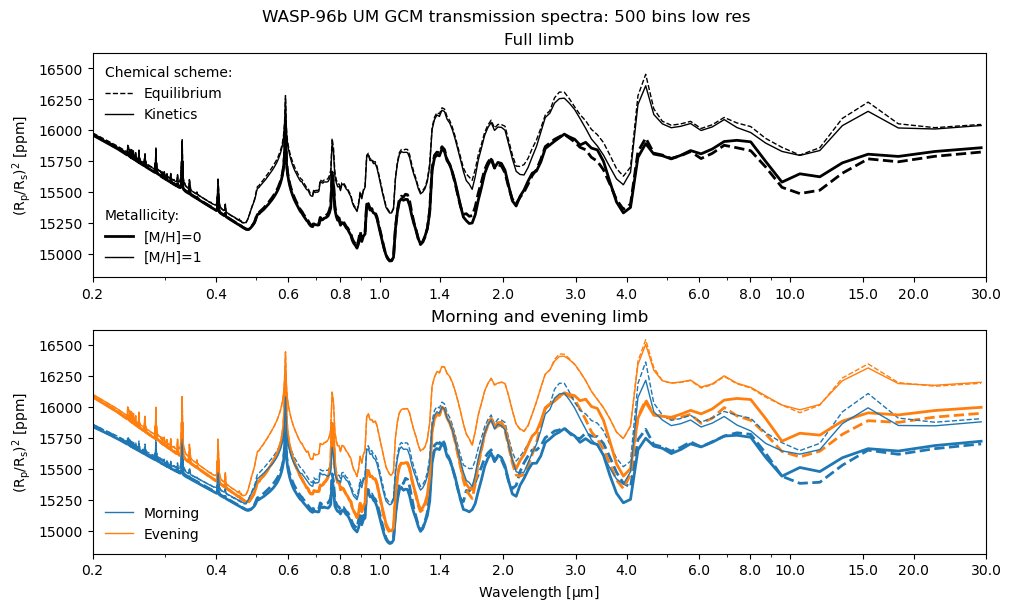

In [9]:
# Plot UM transmission spectra: full, morning and evening
plt_absrbrs = ["all"]
wl_range = "02_30"
if wl_range == "02_30":
    xmin, xmax = 0.2, 30
    xticks = np.concatenate(
        [
            np.array([0.2, 0.4, 0.6, 0.8]),
            np.array([1, 1.4]),
            np.array([2, 3, 4, 6, 8, 10, 15, 20, 30]),
        ]
    )

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharey=True, constrained_layout=True)
for exp, exp_ls in zip(["equilibrium", "kinetics"], ["dashed", "solid"]):
    for mdh, mdh_lw in zip(["mdh_0", "mdh_1"], [2, 1]):
        for absrbr in plt_absrbrs:

            plt_full = rp_over_rs_sqrd[planet][exp][mdh][tK][absrbr]["full"]
            plt_mor = rp_over_rs_sqrd[planet][exp][mdh][tK][absrbr]["morning"]
            plt_eve = rp_over_rs_sqrd[planet][exp][mdh][tK][absrbr]["evening"]
            plt_x = plt_full.coord("spectral_band_centres").points * 1e6  # micrometers

            axs[0].plot(
                plt_x,
                plt_full.data,
                linestyle=exp_ls,
                linewidth=mdh_lw,
                color=ABSORBERS[absrbr]["color"],
            )
            axs[1].plot(
                plt_x,
                plt_mor.data,
                linestyle=exp_ls,
                linewidth=mdh_lw,
                color="C0",
            )
            axs[1].plot(
                plt_x,
                plt_eve.data,
                linestyle=exp_ls,
                linewidth=mdh_lw,
                color="C1",
            )
fig.suptitle(f'{PLANETS[planet]["tex"]} UM GCM transmission spectra: 500 bins low res')
axs[0].set_title("Full limb", loc="center")
axs[1].set_title("Morning and evening limb", loc="center")
axs[1].set_xlabel("Wavelength [$\mu$m]")
for ax in axs.flatten():
    ax.set_xscale("log")
    ax.set_xlim(xmin, xmax)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    ax.set_ylabel("($R_p/R_s)^2$ [ppm]")
# Legends
exp_dict = {
    "Equilibrium": {"color": "k", "ls": "dashed", "lw": 1},
    "Kinetics": {"color": "k", "ls": "solid", "lw": 1},
}
mdh_dict = {
    "[M/H]=0": {"color": "k", "ls": "solid", "lw": 2},
    "[M/H]=1": {"color": "k", "ls": "solid", "lw": 1},
}
limb_dict = {
    "Morning": {"color": "C0", "ls": "solid", "lw": 1},
    "Evening": {"color": "C1", "ls": "solid", "lw": 1},
}
add_custom_legend(
    axs[0], exp_dict, frameon=False, title="Chemical scheme:", alignment="left", loc="upper left"
)
add_custom_legend(
    axs[0],
    mdh_dict,
    frameon=False,
    title="Metallicity:",
    alignment="left",
    loc="lower left",
)
add_custom_legend(axs[1], limb_dict, frameon=False, alignment="left", loc="lower left")
axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

figname = f"{planet}_transpec_wl{wl_range}_{'_'.join(absrbrs)}_full_mor_eve_lowres.png"
# fig.savefig(path_to_project / "transmission" / figname)

In [10]:
# Save to .nc
if check_save_nc:
    for planet in PLANET:
        for exp in ["equilibrium", "kinetics"]:
            for mdh in ["mdh_0", "mdh_1"]:
                for tK in ["tK_6"]:
                    for absrbr in tqdm(absrbrs):
                        for limb in ["full", "morning", "evening"]:
                            fname = f"um_{planet}_{exp[0:3]}_{mdh.replace('_','')}_transpec_lowres_{absrbr}_{limb}.nc"
                            iris.save(
                                rp_over_rs_sqrd[planet][exp][mdh][tK][absrbr][limb],
                                Path.cwd() / "processed" / "transpec_lowres" / fname,
                            )